Code to process data for and plot Figure 1 from Siegfried\*, Venturelli\*, et al. (2023)

This notebook also calculates the scaling ratio between the long-term GPS station (LA09)<br>
and the drill site (LA12/LA17), then estimates the height-change at the drill site between<br>
low stand and high stand in order to compare surface observations (GPS) to lake water column thickness.

Email siegfried@mines.edu and venturelli@mines.edu with any questions

In [1]:
import pygmt
from glob import glob
import pandas as pd
import geopandas as gpd
from pyproj import CRS, Transformer
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString
import numpy as np
import os
import h5py
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import cmocean
import scipy.io as io
import datetime

quickplot = False # boolean to speed up plotting when developing
out='siegvent2023-fig1.pdf' # Name the output file

In [2]:
# Let's hard code a couple important tidbits about drilling

######
# Quick geodetic to PS71 converter from pyproj
def ll2xy(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    
    x, y = ps2ll(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y
######

# Hard code borehole coordinate @ breakthrough, calculated by GPS survey of borehole on 17 Jan, 
# then advected the borehole coordinate based on the change in position of GPS LA17 over the 
# time period between the borehole survey and break through
drill_coord = [-149.50133981653366,-84.6402871908142] # Based on 1 hr survey centered on 17 Jan 2019, 23:30
drillx, drilly = ll2xy(drill_coord[0], drill_coord[1])
breakthrough = 2018 + (360 + (21+34/60)/24 + 13/24 - 1)/365  #26 Dec 2018 21:34 NDZT (UTC - 13) per Priscu et al. (2021)
slwdrill = [-278502.862779,-561384.761658]

In [3]:
## We're going to data wrangle in this cell. 

# set the data paths

# I load in an environment variable that tells me where I store 
# my data. That way if I need to change the path to my data 
# folder (say, point it to an external hard drive if I am in the field) 
# I can make that switch trivially
datafold = os.getenv('DATAHOME')

# quick error check to make sure $DATAHOME is set
if datafold is None:
    raise OSError('environment variable $DATAHOME does not exist')
    
# point to data locations

# MOA available at: 
# https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa125_2009_hp1_v02.0.tif.gz
# (doi: 10.5067/4ZL43A4619AF)
# After unzipping, I then convert it to NetCDF using GMT to reduce data volume by a factor of 4 using the line:
# > gmt grdconvert moa125_2009_hp1_v02.0.tif -Gmoa125_2009_hp1_v02.0.nc
moa = datafold + '/MODIS/MOA/moa125_2009_hp1_v02.0.nc'
# old MOA shapes that are good enough for continent-scale insets (and they're small)
# grounding line: https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/coastlines/moa_2009_groundingline_v02.0.gmt
# coast line: https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/coastlines/moa_2009_coastline_v02.0.gmt
moa_coast = datafold + '/gz/moa/moa_2009_coastline_v02.0.gmt'
moa_gl = datafold + '/gz/moa/moa_2009_groundingline_v02.0.gmt'

# grounding line available at:
# https://doi.pangaea.de/10013/epic.42133.d001 (doi: 10.1594/PANGAEA.819147)
gl = datafold + '/gz/scripps/scripps_antarctica_polygons_v1.shp'

# ice-surface velocity grid available at: 
# https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc
# (doi: 10.5067/PZ3NJ5RXRH10)
vel = datafold + '/velocity/measures-phase_v1/antarctic_ice_vel_phase_map_v01.nc'

# drainage paths from Carter et al., 2013
# Data directly from author
drainage = '../data/isab_drainage.xy'

# download lake outlines from github
lake_outlines = 'SiegfriedFricker2018-outlines.h5'
if (not os.path.exists('SiegfriedFricker2018-outlines.h5')):
    os.system('wget -L https://github.com/mrsiegfried/Siegfried2021-GRL/raw/main/data/outlines/SiegfriedFricker2018-outlines.h5')
lake_outlines = 'SiegfriedFricker2018-outlines.h5'

# location of subglacial lake surface-height change time series
timeseries_dir = 'data/cs2/timeseries'

In [4]:
# define all of our helper functions

######
# process cryosat-2 function 
def process_cs2(cs2fold, salsa_coord_xy, dt, rez):
    # grab files updated to present from Siegfried and Fricker(2021) processing chain
    cs2files = glob(cs2fold + "/*.corr") 
    cs2files.sort() # put it in time order
    
    # initalize empty vectors to store output
    times = []
    data = []
    n_footprints = []
    # loop through each monthly file
    for i in np.arange(0,len(cs2files)):
        yr = cs2files[i][-11:-7] # grab year from file name
        month = cs2files[i][-7:-5] # grab month from file name
        times.append(float(yr) + (float(month)-0.5)/12) # store time of this file
        
        # read cryosat-2 .corr file, which has 3 months of data per file
        df=pd.read_csv(cs2files[i],header=None, skiprows=1, delimiter="\t", 
                       usecols=[0,1,2,3,4,6], names=["x","y","dh","time","sigma0","h_dem"])
        df["h"] = df["dh"] + df["h_dem"] # convert back to elevation (from a reference height and a height change)
        df.drop(["dh","h_dem"], axis = 1, inplace = True) # drop the columns we don't need anymore
        data.append(df) # add to output data
        n_footprints.append(len(df['h'])) # save number of footprints
        
    # loop through each month and make a surface from the data, then interpolate DEM to the requested coordinate
    h_cs2=np.empty((len(times),1)) # output vector for height at coordinate from CryoSat-2
    df_salsa = pd.DataFrame(data = {'x': [salsa_coord_xy[0]], 'y': [salsa_coord_xy[1]]})
    reg=pygmt.info(data[-1][['x','y']], spacing=1000) # get region using pygmt
    rez=500 # resolution of DEM in m

    # do the looping
    for i in np.arange(0,len(times)):
        if np.mod(i,10)==0:
            print(str(i) + " of " + str(len(times)))
        thisdata=data[i] # grab the right dataframe
        thistime=times[i] # grab the right time

        # make a surface in the typical way with PyGMT
        blkmean = pygmt.blockmean(x = thisdata['x'], y = thisdata['y'], z = thisdata['h'], 
                                  spacing = rez, region = reg)
        tmpsurf = pygmt.surface(x = blkmean[0], y = blkmean[1], z = blkmean[2], 
                                spacing = rez, region = reg, T = 0.7)
        tmpsurffilt = pygmt.grdfilter(grid = tmpsurf, filter = "g5000", distance = "0")
        tmpdf = pygmt.grdtrack(points = df_salsa, grid = tmpsurffilt, newcolname='zhat')

        h_cs2[i] = tmpdf['zhat'][0] # save the interpolated elevation at the coordinate
        
    return times, h_cs2, n_footprints # return the stuff we care about
######

######
# process icesat function: takes two tracks and determines height at a specific crossover coordinate
def process_is(is_fold, trk1, trk2, salsa_coord_xy):
    files1288 = glob(is_fold + '/*_' + str(trk1) + '_*.h5') # files for each campaign of track 1
    files0369 = glob(is_fold + '/*_' + str(trk2) + '_*.h5') # files for each campaign of track 2
    
    # load all ICESat data from each track separate pandas dataframes. 
    # Only take data within a 250 m x 250 m box centered on coordiante provides (salsa_coord_xy). 
    dx = 250
    dfs = []; # empty vector to store dataframes
    for f in files1288:
        with h5py.File(f, 'r') as fi:
            is_x = fi['/x'][0,:]
            is_y = fi['/y'][0,:]
            is_z = fi['/elev'][0,:]
            is_gain = fi['/gain'][0,:]
            is_t = fi['/t_fracyr'][0,:]
            camp = fi.attrs['campaign'].decode('UTF-8')
            trk = fi.attrs['track'][0]
        idx = (is_x<salsa_coord_xy[0]+dx) & (is_x > salsa_coord_xy[0]-dx) & (is_y<salsa_coord_xy[1]+dx) & (is_y > salsa_coord_xy[1]-dx)
        if sum(idx) >= 0:
            dfs.append(pd.DataFrame({'x': is_x[idx], 
                                     'y': is_y[idx], 
                                     'h': is_z[idx], 
                                     't_fracyr': is_t[idx], 
                                     'gain': is_gain[idx],
                                     'camp': [camp] * len(is_x[idx]),
                                     'track': [trk] * len(is_x[idx])}))
    t1288 = pd.concat(dfs) # merge into one dataframe for the track

    dfs = []; # empty vector to store dataframes
    for f in files0369:
        with h5py.File(f, 'r') as fi:
            is_x = fi['/x'][0,:]
            is_y = fi['/y'][0,:]
            is_z = fi['/elev'][0,:]
            is_gain = fi['/gain'][0,:]
            is_t = fi['/t_fracyr'][0,:]
            camp = fi.attrs['campaign'].decode('UTF-8')
            trk = fi.attrs['track'][0]
        idx = (is_x<salsa_coord_xy[0]+dx) & (is_x > salsa_coord_xy[0]-dx) & (is_y<salsa_coord_xy[1]+dx) & (is_y > salsa_coord_xy[1]-dx)
        if sum(idx) >= 0:
            dfs.append(pd.DataFrame({'x': is_x[idx], 
                                     'y': is_y[idx], 
                                     'h': is_z[idx], 
                                     't_fracyr': is_t[idx], 
                                     'gain': is_gain[idx],
                                     'camp': [camp] * len(is_x[idx]),
                                     'track': [trk] * len(is_x[idx])}))
    t0369 = pd.concat(dfs)# merge into one dataframe for the track
    
    # make a single dataframe with all the data
    isdata = pd.concat([t0369,t1288])
    print("total points: " + str(len(isdata['x'])))
    
    # solve a linear system based on Smith et al., 2009 -- this is needed to move the height time series to the drill site
    xs = isdata['x']
    xbar = np.mean(xs)
    ys = isdata['y']
    ybar = np.mean(ys)
    zs = isdata['h']
    zbar = np.mean(zs)
    ts = isdata['t_fracyr']
    tbar = np.mean(ts)

    G = np.ones((len(xs),4))
    G[:,0] = xs-xbar
    G[:,1] = ys-ybar
    G[:,2] = ts - tbar

    coeffs = np.linalg.lstsq(G,zs, rcond=None)[0]
    isdata['resid'] = zs - np.matmul(G,coeffs)

    # solve the linear model at the coordinate we care about
    isdata['z_drillsite'] = coeffs[0]*(salsa_coord_xy[0]-xbar) + coeffs[1]*(salsa_coord_xy[1]-ybar) + coeffs[2]*(ts-tbar) + coeffs[3] + isdata['resid']

    # do some fancy pandas work to average the data in the right spots
    isdata_grouped = isdata.groupby(['camp','track']).agg({'z_drillsite': ['mean','std'], 't_fracyr': ['mean']})
    isdata_grouped = isdata_grouped.sort_values(('t_fracyr','mean'))
    is_t = isdata_grouped['t_fracyr']['mean'].values
    is_h = isdata_grouped['z_drillsite']['mean'].values
    is_h_std = isdata_grouped['z_drillsite']['std'].values
    
    return is_t,is_h,is_h_std
######

######
# function to process ICESat-2 data
def process_is2(is2_file, times, salsa_coord_xy, dt, rez):
    is2data=pd.read_pickle(is2file) # read the is2 data from a pre-made pickle file for speed
    reg=pygmt.info(is2data[['x','y']], spacing=1000) # get GMT region
    df_salsa = pd.DataFrame(data = {'x': [salsa_coord_xy[0]], 'y': [salsa_coord_xy[1]]}) 
    h_is2 = np.empty((len(times),1)) # initialize the output vector
    n_is2 = np.empty((len(times),1)) # initialize the number of datapoints output vector

    # loop through each time step, make a surface from 3 months of data centered on that time step, interpolate to coordinate
    for i in np.arange(0,len(times)):
        thistime=times[i] # grab time
        idx = is2data['t_fracyr'].between(times[i]-dt/2,times[i]+dt/2) # find data in the time window centered on this time step
        if sum(idx)>0: # only do this if there is more than 0 data
            # print something sometimes so we know this is working
            if thistime-np.floor(thistime)<0.1:
                print(str(np.floor(thistime))) 
            # make a surface in the typical pyGMT way
            blkmean = pygmt.blockmean(x = is2data['x'].loc[idx], 
                                      y = is2data['y'].loc[idx], 
                                      z = is2data['h'].loc[idx], 
                                      spacing = rez, region = reg)
            tmpsurf = pygmt.surface(x = blkmean[0], y = blkmean[1], z = blkmean[2], spacing = rez, region = reg, T = 0.7)
            tmpsurffilt = pygmt.grdfilter(grid = tmpsurf, filter = "g1750", distance = "0")
            tmpdf = pygmt.grdtrack(points = df_salsa, grid = tmpsurffilt, newcolname='zhat') # interpolate to coordinate
            h_is2[i] = tmpdf['zhat'][0] # save interpolated elevation
            n_is2[i] = len(is2data['x'].loc[idx]) # save number of footprints in the DEM
        h_is2[h_is2<10]=np.nan # if we have < 10 footprints, throw the data out
    
    return h_is2, n_is2
######

######
# load and decimate GPS data
def gps_make_daily(fold, station):
    # grab all the full resolution GPS position data saved as annual files
    gps_files = glob(fold + '/' + station + '*.xyzt') 
    dfs = [] # vector to save dataframes
    # read each annual file into a dataframe, and store the dataframe
    for f in gps_files:
        print(f)
        df = pd.read_csv(f, delimiter='\t', header=None, names=['x','y','z','year','frac_doy'])
        dfs.append(df)
    pos = pd.concat(dfs) # combine all dataframes for a massive GPS dataframe for the station

    # use fancy pandas math to calculate daily positions with statistics, as well as convert time to decimal years
    pos['doy'] = np.floor(pos['frac_doy'])
    daily = pos.groupby(['year','doy'], as_index = False).agg({'x': 'median', 'y': 'median', 'z': ['median','std','count'], 'year': 'median'})
    # replace height values with only a few epochs with nan
    daily.loc[daily[('z','count')] < 2*60, ('z','median')] = np.nan
    daily['ndays'] = [365] * len(daily[('z','median')])
    daily.loc[np.mod(daily[('year','median')],4) == 0,'ndays']=366
    daily['fracyr'] = (daily['doy']-1)/daily['ndays'] + daily['year']['median']
    return daily
######

######
# load GNSS-IR results from each station into a big ol' pandas dataframe
def gps_load_reflector_height(fold, station):
    result = pd.DataFrame()
    colnames=['year', 'doy', 'RH', 'Sat','UTCtime', 'Azim', 'Amp',  'eminO', 'emaxO','NumbOf','Freq','rise','EdotF','PkNoise','DelT','MJD','refr-appl'] 
    years = [f.path[-4:] for f in os.scandir(fold) if (f.is_dir()) & (f.path[-4] == '2')]
    for year in years:
        print("loading " + station + " data from " + year + ".")
        directory = fold +'/' + year + '/results/' + station
        files = glob(directory + "/*.txt")
        for f in files:
            df1 = pd.read_csv(f, header = 4, delim_whitespace = True, names=colnames, dtype=np.float64)
            statname = [station]*len(df1.year)
            df1['StationName'] = statname
            merge = [result,df1]
            result = pd.concat(merge)
            
    # do some fancy pandas math to massage data with statistics we want to keep
    stats = result.groupby(['doy','year','StationName'], as_index = False).agg({'year': 'median', 'RH': ['median', 'count', 'std']})
    stats['ndays'] = [365] * len(stats[('RH','median')])
    stats.loc[np.mod(stats[('year','median')],4) == 0,'ndays'] = 366
    stats['fracyr'] = (stats['doy']-1)/stats['ndays'] + stats[('year','median')]
    
    return stats
######

In [5]:
# Process ICESat, CryoSat-2, and ICESat-2 data
dt = 3/12 # moving 3 month window for CryoSat-2 and ICESat-2 processing

# process ICESat data
is_fold = '../data/is'
track1 = '1288'
track2 = '369'
is_t, is_h, is_h_std = process_is(is_fold, track1, track2, [drillx, drilly])
print('done processing icesat data')

# process CryoSat-2 data
cs2fold = "../data/cs2/slm_corr"
rez=500
times, h_cs2, h_footprints = process_cs2(cs2fold, [drillx,drilly], dt, rez)
print('done processing cryosat-2 data')

# process ICESat-2
is2file = "../data/is2/MercerSubglacialLake.is2.atl06.004.pkl"
rez = 250
h_is2, n_is2 = process_is2(is2file, times, [drillx, drilly], dt, rez)
print ('done processing icesat-2 data')

total points: 61
done processing icesat data
0 of 129
10 of 129
20 of 129
30 of 129
40 of 129
50 of 129
60 of 129
70 of 129
80 of 129
90 of 129
100 of 129
110 of 129
120 of 129
done processing cryosat-2 data
2019.0
2020.0
2021.0
done processing icesat-2 data


In [6]:
# Load and decimate GPS data for three stations

gpsfold = '../data/gps/positions'
la09_daily = gps_make_daily(gpsfold, 'la09')
la12_daily = gps_make_daily(gpsfold, 'la12')
la17_daily = gps_make_daily(gpsfold, 'la17')
print('positions loaded')

gnssir_fold = '../data/gps/gnssir'
la09ir = gps_load_reflector_height(gnssir_fold, 'la09')
la12ir = gps_load_reflector_height(gnssir_fold, 'la12')
la17ir = gps_load_reflector_height(gnssir_fold, 'la17')
print('reflector heights loaded')

#merge raw gps with reflector heights so we can get a snow surface time series
la09 = pd.merge(la09_daily,la09ir, how = 'left', on = ('doy',('year','median'), 'ndays', 'fracyr'))
la12 = pd.merge(la12_daily,la12ir, how = 'left', on = ('doy',('year','median'), 'ndays', 'fracyr'))
la17 = pd.merge(la17_daily,la17ir, how = 'left', on = ('doy',('year','median'), 'ndays', 'fracyr'))
print('gps data merged')

../data/gps/positions/la092011.xyzt
../data/gps/positions/la092010.xyzt
../data/gps/positions/la092017.xyzt
../data/gps/positions/la092016.xyzt
../data/gps/positions/la092015.xyzt
../data/gps/positions/la092019.xyzt
../data/gps/positions/la092018.xyzt
../data/gps/positions/la092014.xyzt
../data/gps/positions/la092009.xyzt
../data/gps/positions/la092013.xyzt
../data/gps/positions/la092012.xyzt
../data/gps/positions/la092008.xyzt
../data/gps/positions/la122013.xyzt
../data/gps/positions/la122012.xyzt
../data/gps/positions/la122014.xyzt
../data/gps/positions/la172019.xyzt
../data/gps/positions/la172018.xyzt
../data/gps/positions/la172017.xyzt
../data/gps/positions/la172016.xyzt
positions loaded
loading la09 data from 2013.
loading la09 data from 2014.
loading la09 data from 2015.
loading la09 data from 2012.
loading la09 data from 2008.
loading la09 data from 2009.
loading la09 data from 2017.
loading la09 data from 2010.
loading la09 data from 2019.
loading la09 data from 2018.
loading l

/Users/siegfried/opt/miniconda3/envs/siegvent2023/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
# load subglacial lakes ad drainage paths

# open lake outlines hdf5 file
h5f = h5py.File(lake_outlines, 'r')

outline_geometries = [] # store polygons
# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)
    
    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
    else:
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]
        
        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]
            pgons.append(Polygon(this_outline))
        geometry = MultiPolygon(pgons)
        
    # append all the results in the right place
    outline_geometries.append(geometry)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries), 
                  columns=['name', 'geometry'])
gdf = gpd.GeoDataFrame(df, crs=CRS("EPSG:3031"), geometry=outline_geometries)
h5f.close()

### load GZ
df_gl = gpd.read_file(gl)


### load drainage paths
df_drainage = pd.read_csv(drainage, 
                          header = None, 
                          names = ['x','y'], 
                          delimiter = ' ')
#split the data frame at nans
segs = np.split(df_drainage, np.where(np.isnan(df_drainage.x))[0])
# removing NaN entries
segs = [seg[~np.isnan(seg.x)] for seg in segs if not isinstance(seg, np.ndarray)]
# removing empty DataFrames
segs = [seg for seg in segs if not seg.empty]

# some fancy geopandas work to get the drainage paths into geopandas, then crop at grounding line
geoms = []
for s in segs:
    s['coords'] = s.apply(lambda row: (row['x'], row['y']), axis=1)
    geometry = LineString(s['coords'].to_list())
    geoms.append(geometry)
drainpath = gpd.GeoSeries(MultiLineString(geoms))
drainpath = gpd.GeoDataFrame(drainpath, geometry = drainpath, crs = CRS("EPSG:3031"))

drainpath = gpd.overlay(drainpath, gdf, how = 'difference')
drainpath = gpd.overlay(drainpath, df_gl.loc[121:121], how = 'difference')

## Calculate the scaling ratio between LA09 and the drill site 

Because all the data are loaded, let's determine dH at the drill site between low stand and high stand

In [33]:
#### CALCULATE THE EFFETIVE HEIGHT CHANGE FROM LOW STAND AT DRILL SITE
la12['h_surf'] = la12[('z','median')] - la12[('RH','median')]
la17['h_surf'] = la17[('z','median')] - la17[('RH','median')]
la09['h_surf'] = la09[('z','median')] - la09[('RH','median')]


mkratio1 = pd.merge(la12,la09, how = 'left', on = ['doy',('year','median')])
Zx1, Zx2 = np.meshgrid(mkratio1[('h_surf_x')], mkratio1[('h_surf_x')])
dZx = np.tril(Zx1) - np.tril(Zx2) # matrix is symmetric---just use lower triangle
Zy1, Zy2 = np.meshgrid(mkratio1[('h_surf_y')], mkratio1[('h_surf_y')])
dZy = np.tril(Zy1) - np.tril(Zy2) # matrix is symmetric---just use lower triangle

dZx[dZx<11] = np.nan
dZy[dZy<11] = np.nan
dz_ratio1 = dZx.flatten()/dZy.flatten()

mkratio1 = pd.merge(la17,la09, how = 'left', on = ['doy',('year','median')])
Zx1, Zx2 = np.meshgrid(mkratio1[('h_surf_x')], mkratio1[('h_surf_x')])
dZx = np.tril(Zx1) - np.tril(Zx2) # matrix is symmetric---just use lower triangle
Zy1, Zy2 = np.meshgrid(mkratio1[('h_surf_y')], mkratio1[('h_surf_y')])
dZy = np.tril(Zy1) - np.tril(Zy2) # matrix is symmetric---just use lower triangle

dZx[dZx<11] = np.nan
dZy[dZy<11] = np.nan
dz_ratio2 = dZx.flatten()/dZy.flatten()

dz_ratio = np.concatenate((dz_ratio1,dz_ratio2))
print("ratio mean +/- sigma: " + str(np.nanmean(dz_ratio)) + " +/- " + str(np.nanstd(dz_ratio)))

h_access = la09.h_surf[(la09_daily[('year','median')] == 2018) & (la09_daily.doy == 360)]
h_lowstand = la09[('h_surf')].min()
dH_la09 = np.round(h_access - h_lowstand, decimals = 2)

dH_drillsite = dH_la09*np.round(np.nanmean(dz_ratio), decimals=2)
dH_drillsite_std = np.nanstd(dz_ratio)*dH_la09.iloc[0]
print("dH at drill site is: " + str(dH_drillsite.iloc[0]) + ' +/- ' + str(dH_drillsite_std))


ratio mean +/- sigma: 1.1937448097649739 +/- 0.0245826027811643
dH at drill site is: 14.9464 +/- 0.30875749093142363


/Users/siegfried/opt/miniconda3/envs/siegvent2023/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Finally, let's start actually plotting the figure

basemap [WARNING]: For a UTM or TM projection, your region -394999.7865019918/-194999.7865019918/-572469.8182877477/-472469.81828774774 is too large to be in degrees and thus assumed to be in meters


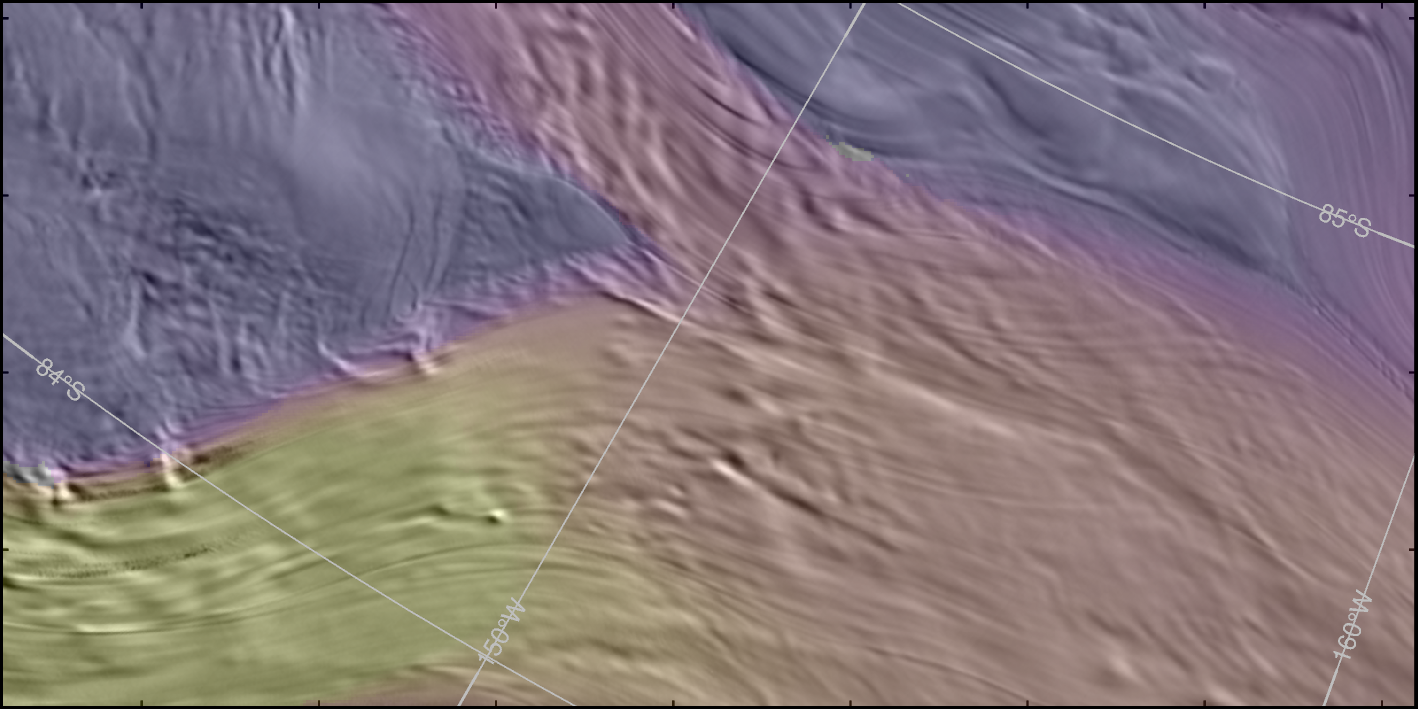

In [8]:
figwidth=120 # in mm

# Region for main part of the figure

#   calculate centroid of SLM
slm_poly = gdf.loc[gdf['name'] == 'MercerSubglacialLake','geometry']
center_x = slm_poly.centroid.x.to_list()
center_y = slm_poly.centroid.y.to_list()
wid_km = 200
hgt_km = 100
slm_xl=center_x[0] - wid_km*1000/4*2
slm_xh=center_x[0] + wid_km*1000/4*2
slm_yl=center_y[0] - hgt_km*1000/3*2 - 5000
slm_yh=center_y[0] + hgt_km*1000/3*1 - 5000

slmratio = (slm_xh - slm_xl) / (figwidth/1000)
figheight=figwidth*(slm_yh-slm_yl)/(slm_xh-slm_xl)

slmreg = str(slm_xl) + '/' + str(slm_xh) + '/' + str(slm_yl) + '/' + str(slm_yh)
slmproj = "x1:" + str(slmratio)
slmproj_ll = "s0/-90/-71/1:" + str(slmratio)

pygmt.makecpt(series = '15000/17000/1', cmap = 'gray', continuous = True, output = 'moa.cpt')
with pygmt.config(COLOR_FOREGROUND = '240/249/33', COLOR_BACKGROUND = '13/8/135'):
    pygmt.makecpt(series = [0,500,1], cmap = 'plasma', output = 'vel.cpt')
#pygmt.makecpt(series = '-5/20/1', cmap = 'viridis', output = 'dz.cpt')
fig = pygmt.Figure()
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = slmreg, projection = slmproj, frame=["nwse", "xf25000", "yf25000"], 
                 grid = moa, cmap = 'moa.cpt')

if (not quickplot):
    veldata = xr.open_dataset(vel)
    vel_mag = (veldata['VX']**2 + veldata['VY']**2)**0.5
    fig.grdimage(grid = vel_mag, cmap = 'vel.cpt', transparency = 80)

    # Plot graticules overtop, at 2d latitude and 15d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '6p,grey',
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinner,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = slmproj_ll, region = slmreg,
                frame = ["SnWE", "xa10g10", "ya1g1"])
    
fig.show()

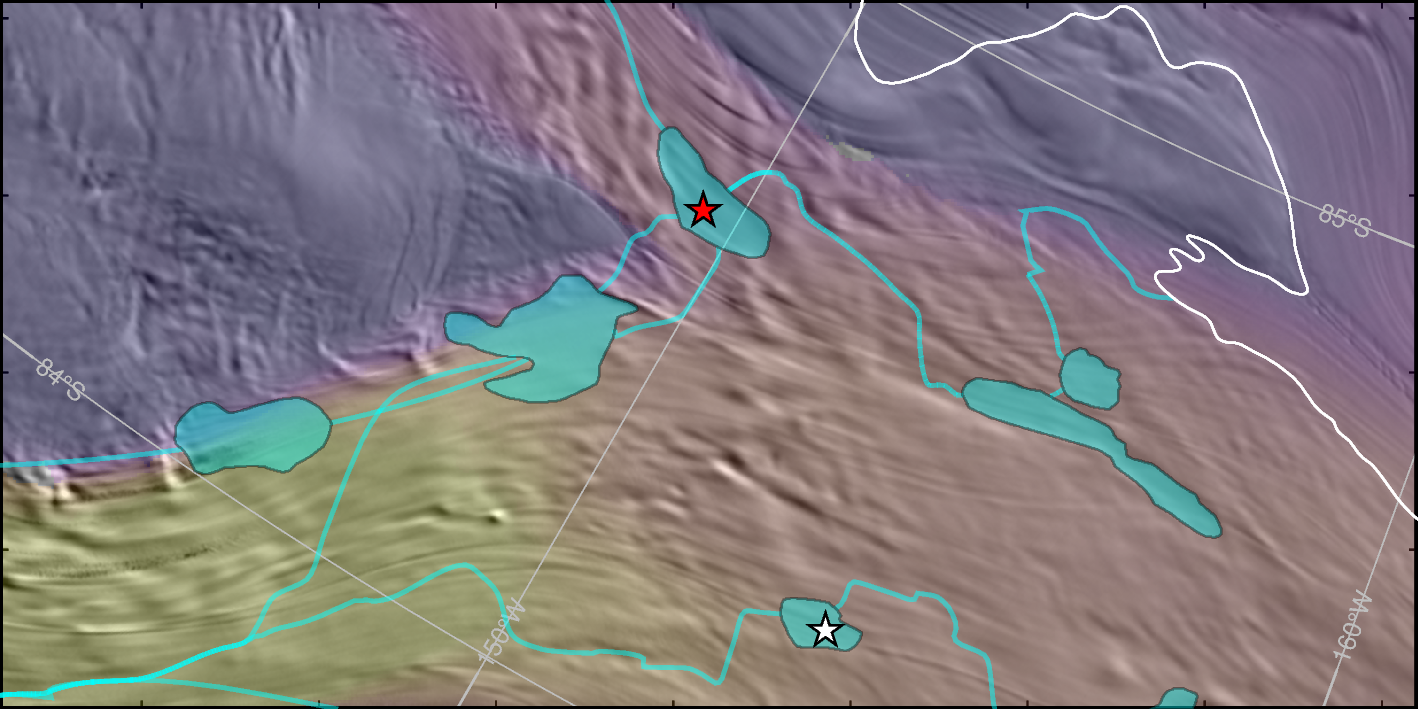

In [9]:
if not quickplot:
    fig.plot(region = slmreg, projection = slmproj, 
             data = drainpath['geometry'], pen = "1p,cyan", transparency = 50)
    fig.plot(data = gdf, 
             pen = "0.5p,black", 
             color = 'cyan', 
             transparency = 60)
    fig.plot(data = gl, pen = '0.5p,white')   

# plot drill sites
fig.plot(region = slmreg, projection = slmproj, 
         x = drillx, y = drilly, style = 'a0.3c', pen='0.5p,black', color = 'red')
fig.plot(x = slwdrill[0], y = slwdrill[1], style = 'a0.3c', pen='0.5p,black', color = 'white')

fig.show()

In [10]:
#######
## Plot scale bar in lower left
wid = 20000 # scale bar width, in m
xoff = 4000 # distance from left to put scale bar, in m
yoff = 4000 # distance from bottom to put scale bar, in m

xleft = xoff
xmid = xoff + wid/2
xright = xoff + wid

fig.plot(x = [slm_xl + xleft, slm_xl + xright], y = [slm_yl + yoff, slm_yl + yoff], pen = '1.5p,white')
fig.text(x = slm_xl + xmid, y = slm_yl + yoff, text = '{:3.0f}'.format(wid/1000) + ' km', 
         font = '8p,Helvetica-Bold,white', justify = 'BC', offset = '0/0.1c')

# plot letter in upper right (9 pt helvetica)
fig.text(x = slm_xl, y = slm_yh, text = 'A.', 
         font = '9p,Helvetica-Bold,white', justify = 'TL', offset = '0.1c/-0.1c')

!echo -204000 -514000 MC Ross > tmptxt
!echo -204000 -519000 MC Ice >> tmptxt
!echo -204000 -524000 MC Shelf >> tmptxt
!echo -308000 -520000 TL SLC >> tmptxt
!echo -367000 -540000 TL USLC >> tmptxt
!echo -286000 -493000 MR SLM >> tmptxt
!echo -282000 -554000 MR SLW >> tmptxt
fig.text(textfiles = 'tmptxt', font = '8p,Helvetica-Bold,white', justify = True)
os.remove('tmptxt')

!echo -336000 -540000 MC Whillans > tmptxt
!echo -333500 -545000 MC Ice Stream >> tmptxt
fig.text(textfiles = 'tmptxt', font = '8p,Helvetica-Bold,white', justify = True, angle = 20)
os.remove('tmptxt')
#######

!echo -312000 -482000 MC Mercer > tmptxt
!echo -316000 -485500 MC Ice Stream >> tmptxt
fig.text(textfiles = 'tmptxt', font = '8p,Helvetica-Bold,white', justify = True, angle = -50)
os.remove('tmptxt')
#######

fig.show()

In [11]:
#######
## Plot legend with symbols; plot scale bars below the figure
# make legend file and plot it
!echo 'S - a 0.3c white 0.25p,black - drill sites' > legend.txt
!echo 'S - - 0.2c - 1p,cyan - water flowpath' >> legend.txt
!echo 'S - - 0.2c - 1p,white - grounding line' >> legend.txt
with pygmt.config(FONT_ANNOT_PRIMARY = '8p', FONT_LABEL='8p,Helvetica', 
                  MAP_FRAME_PEN = '0.5p'):
    fig.legend(region = slmreg, projection = slmproj, 
               spec = 'legend.txt', position = 'JBR+jBR+o0.1c', 
               box = '+gwhite+p0.5p', transparency = 30)
    fig.legend(spec = 'legend.txt', position = 'JBR+jBR+o0.1c')
os.remove('legend.txt')

# make the velocity colorbar 20% figure length, in the upper right
barwidth = figwidth/10 * 0.2
pos_str = 'n1/1+w' + str(barwidth) + 'c+h+ml+jTR+o0.45c/0.6c'
with pygmt.config(FONT_ANNOT_PRIMARY = '8p', FONT_LABEL = '8p', 
                  MAP_ANNOT_OFFSET_PRIMARY = '2p', MAP_TICK_PEN_PRIMARY = '0.5p', 
                  MAP_TICK_LENGTH_PRIMARY = '3p', MAP_FRAME_PEN = '0.5p', MAP_LABEL_OFFSET = '4p'):
    fig.colorbar(cmap = 'vel.cpt', position = pos_str, box = '+gwhite+p0.5p',
                 frame = 'xa250f50+l"ice velocity [m a@+-1@+]"', transparency = 30) 
    fig.colorbar(cmap = 'vel.cpt', position = pos_str, frame = 'xa250f50+l"ice velocity [m a@+-1@+]"') 
#######


# Make insets
antwidth = 2.5 # width of inset in cm
antreg = '-2900000/-2900000/2900000/2900000r'
antmap = 'X' + str(antwidth) + 'c'

# generate offset string based on inset width
xoff_str = 'a' + str(0.05) + 'c'
yoff_str = 'a' + str(figheight/10 - antwidth - 0.05) + 'c'

fig.basemap(projection = antmap, region = antreg, frame = '+n', xshift = xoff_str, yshift = yoff_str)
fig.plot(data = moa_coast, color = 'white', xshift = xoff_str, yshift = yoff_str)
fig.plot(data = moa_gl, color = 'gray', xshift = xoff_str, yshift = yoff_str)
fig.plot(x = [slm_xl, slm_xl, slm_xh, slm_xh, slm_xl], y = [slm_yl, slm_yh, slm_yh, slm_yl, slm_yl], 
         pen = '1p,black', xshift = xoff_str, yshift = yoff_str)

fig.show()

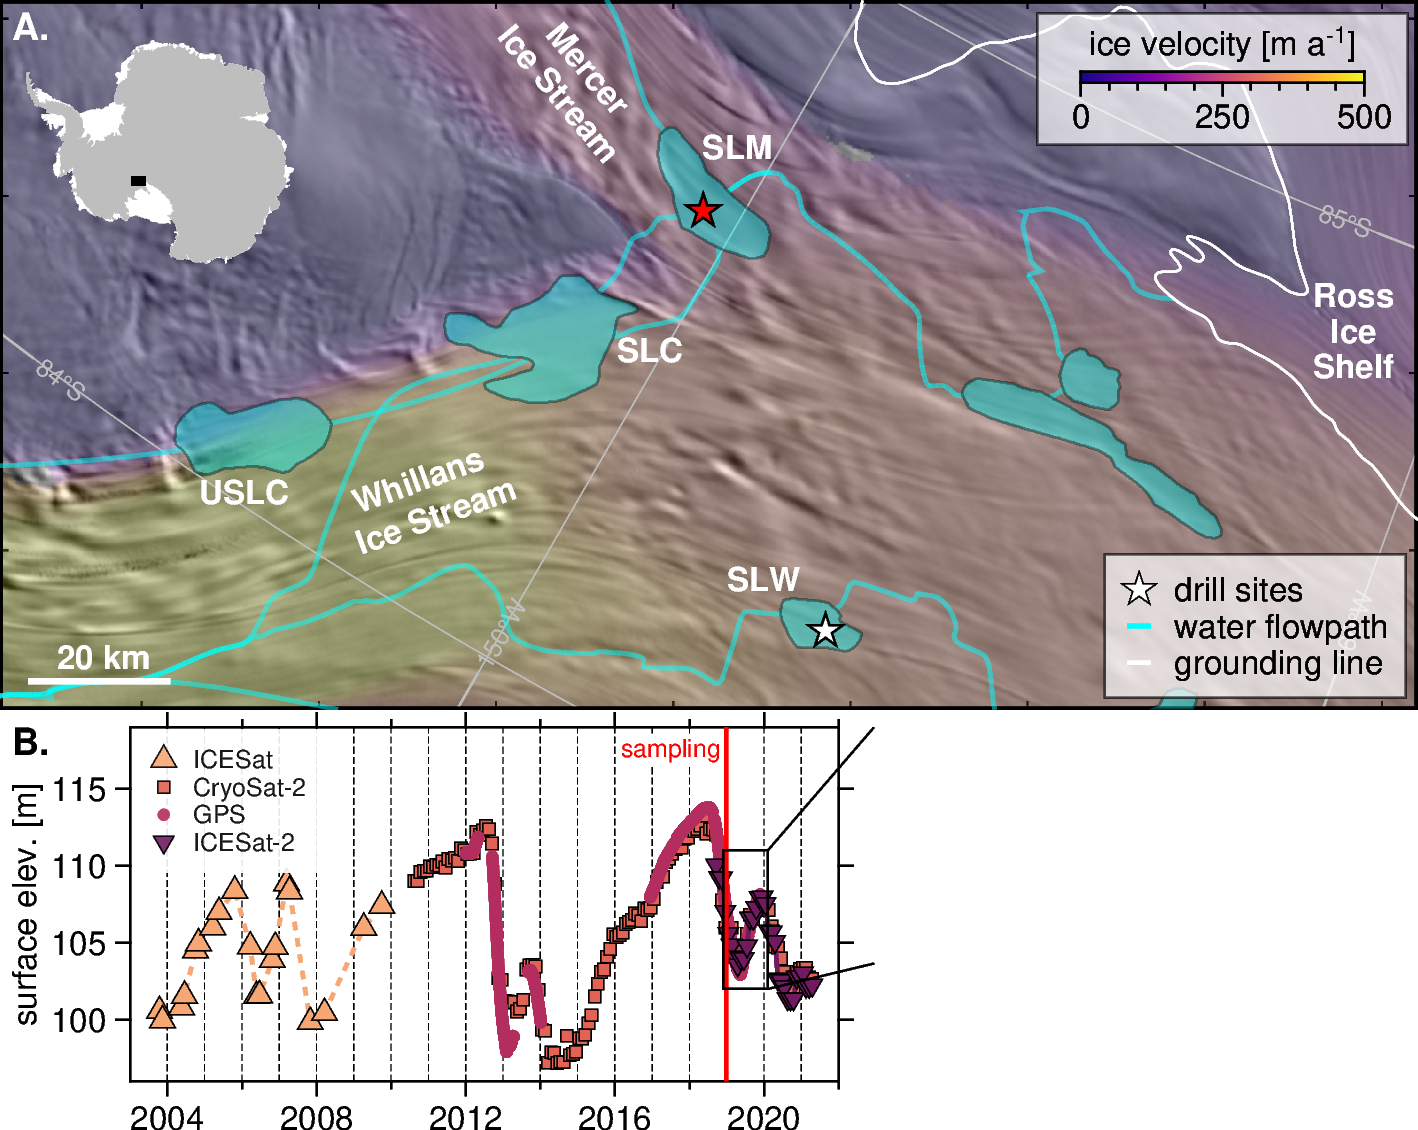

In [12]:
inset_t_min = 2018.9
inset_t_max = 2020.1
inset_h_min = 102
inset_h_max = 111

t_min = 2003
t_max = 2022
h_max = 119
h_min = 96
ts_reg = str(t_min) + '/' + str(t_max) + '/' + str(h_min) + '/' + str(h_max)
wid = 6 # in cm 
hgt = wid/2

x_off = 0.3 #in cm
t_off = (t_max - t_min)/wid * x_off
yskip = 0.75 # in cm

ts_proj = 'X' + str(wid) + 'c/' + str(hgt) + 'c'
with pygmt.config(FONT_LABEL='8p,Helvetica', FONT_ANNOT_PRIMARY = '8p,Helvetica', 
                  MAP_GRID_PEN_PRIMARY = '0.5p,black,dashed'):
    fig.basemap(region = ts_reg, projection = ts_proj,
                yshift = str(-hgt-0.15) + 'c', xshift = '1.1c', 
                frame=['nWSe', 'xa4f2g1', 'ya5'])
fig.text(x = t_min, y = (h_min+h_max)/2, text = 'surface elev. [m]',
         font = '8p,Helvetica,black', justify = 'BC', angle = 90,
         offset = '-0.8c/0c', no_clip = True)    

####### plot the data
cb = cmocean.tools.get_dict(cmocean.cm.matter, N=6)

# plot icesat data
is_color = str(cb['red'][1][1]*255)+'/'+str(cb['green'][1][1]*255)+'/'+str(cb['blue'][1][1]*255)
fig.plot(x = is_t, y = is_h, pen = '1p,'+is_color+',2_2:0p')
fig.plot(x = is_t, y = is_h, style = 't0.25c',  pen = '0.25p,black',
         color = is_color, label = 'ICESat')

# plot CryoSat-2 data
#ax.plot(times,h_cs2,'s',color=(cb['red'][1][1], cb['green'][1][1], cb['blue'][1][1]),label='CryoSat-2', mec='black')
cs2_color = str(cb['red'][2][1]*255)+'/'+str(cb['green'][2][1]*255)+'/'+str(cb['blue'][2][1]*255)
fig.plot(x = times, y = h_cs2[:,0], style = 's0.15c', pen = '0.25p,black', 
         color = cs2_color, label = 'CryoSat-2')

# plot gps data
gps_color = str(cb['red'][3][1]*255)+'/'+str(cb['green'][3][1]*255)+'/'+str(cb['blue'][3][1]*255)
fig.plot(x = la12['fracyr'], y = la12[('z','median')] - la12[('RH','median')], 
         style = 'c0.1c', color = gps_color, label = 'GPS')
fig.plot(x = la17['fracyr'], y = la17[('z','median')] - la17[('RH','median')], 
         style = 'c0.1c', color = gps_color)


# plot ICESat-2 data
is2_color = str(cb['red'][4][1]*255)+'/'+str(cb['green'][4][1]*255)+'/'+str(cb['blue'][4][1]*255)
#ax.plot(times,h_is2,color = (cb['red'][4][1], cb['green'][4][1], cb['blue'][4][1]), lw=2)
#ax.plot(times,h_is2,'v', label='ICESat-2', markersize=10, mec='black',
#        color = (cb['red'][4][1], cb['green'][4][1], cb['blue'][4][1]))
fig.plot(x = times, y = h_is2[:,0], pen = '1p,'+is2_color)
fig.plot(x = times, y = h_is2[:,0], style = 'i0.2c', pen = '0.25p,black', 
         color = is2_color, label = 'ICESat-2')
#######

with pygmt.config(FONT_ANNOT_PRIMARY='6p,Helvetica'):
    fig.legend(transparency=10, position = 'JTL+jTL+o0.02c', box = '+gwhite+c0c/0c')
 

fig.plot(x = [breakthrough,breakthrough], y = [h_min,h_max], pen = '1p,red')
fig.text(x = [breakthrough], y = h_max, text = 'sampling', 
         font = '6p,Helvetica,red', justify = 'TR', offset='-0.05c/-0.1c', fill='white')
fig.plot(x = [inset_t_min, inset_t_min, inset_t_max, inset_t_max, inset_t_min], 
         y = [inset_h_min, inset_h_max, inset_h_max, inset_h_min, inset_h_min], 
         pen = '0.5p,black')

# plot letter in upper left (9 pt helvetica)
fig.text(x = t_min, y = h_max, text = 'B.', 
         font = '9p,Helvetica-Bold,black', justify = 'TL', 
         offset = '-1c/0c', no_clip = True)

newproj = 'X' + str(wid + x_off) + 'c/' + str(hgt) + 'c'
newreg = str(t_min) + '/' + str(t_max+t_off) + '/' + str(h_min) + '/' + str(h_max)
fig.plot(region = newreg, projection = newproj,
         x = [inset_t_max, t_max+t_off], y = [inset_h_max, h_max], 
         pen = '0.5p,black', no_clip = True)
fig.plot(x = [inset_t_max, t_max+t_off], y = [inset_h_min, h_min+(h_max-h_min)/3], 
         pen = '0.5p,black', no_clip = True)

fig.show()

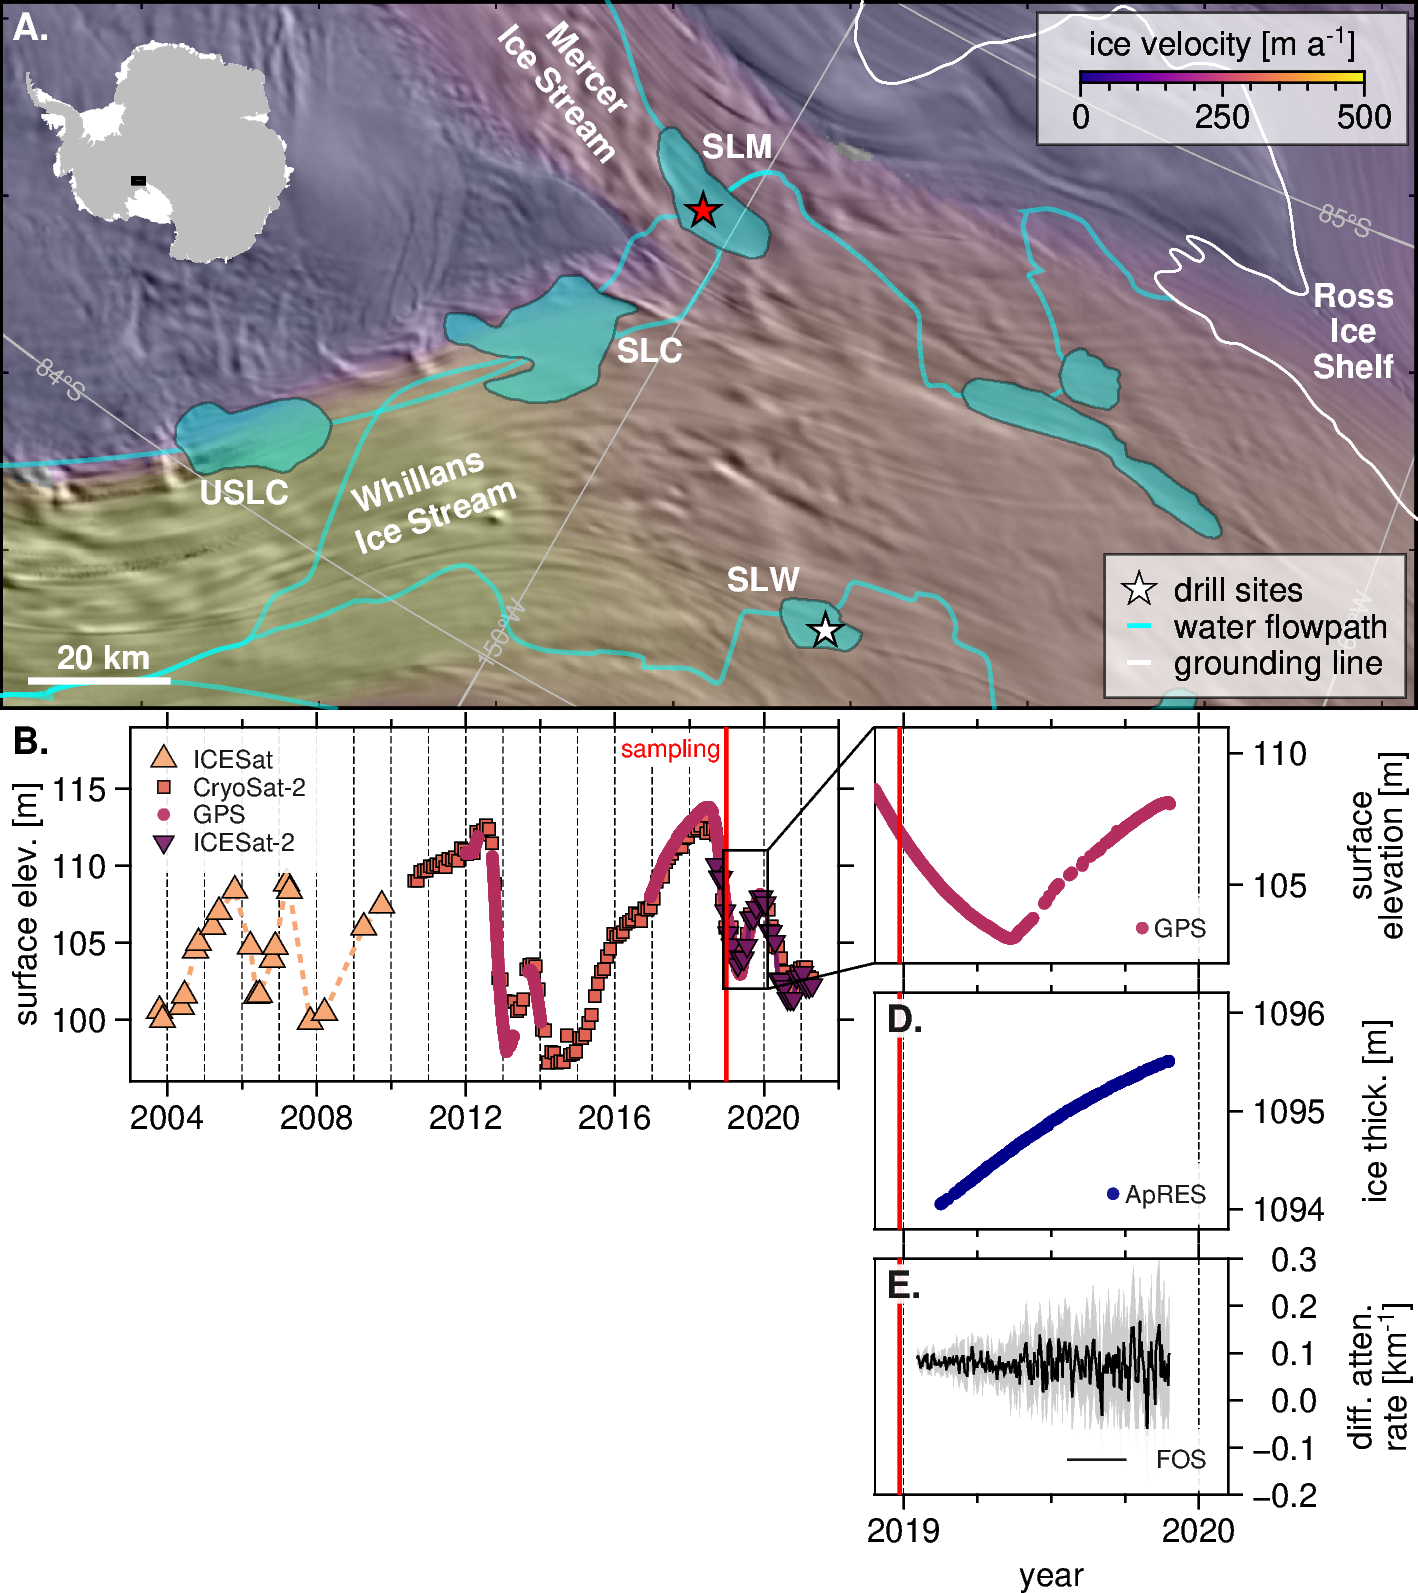

In [13]:
inset_reg = str(inset_t_min) + '/' + str(inset_t_max) + '/' + str(inset_h_min) + '/' + str(inset_h_max)
inset_wid = wid/2
inset_hgt = hgt/3*2
inset_proj = 'X' + str(inset_wid) + 'c/' + str(inset_hgt) + 'c'

xshift = str(wid + x_off) + 'c'

l0_off = '1c/0c'
l1_off = '1.13c/0c'
l2_off = '1.26c/0'

######## GPS DURING LAKE GEOPHYSICS YEAR
with pygmt.config(FONT_LABEL='8p,Helvetica', FONT_ANNOT_PRIMARY = '8p,Helvetica'):
    fig.basemap(region = inset_reg, projection = inset_proj,
                yshift = str(inset_hgt/2) + 'c', xshift = xshift, 
                frame=['nsE', 'xa1f0.25g1', 'ya5'])
    fig.plot(x = [inset_t_min, inset_t_min], y = [inset_h_min, inset_h_max], pen = "0.75p,black")
    fig.text(x = inset_t_max, y = (inset_h_min+inset_h_max)/2, 
             text = 'surface', justify = 'TC', offset = l0_off, 
             font = '8p,Helvetica,black', no_clip = True, angle = 90)
    fig.text(x = inset_t_max, y = (inset_h_min+inset_h_max)/2, 
             text = 'elevation [m]', justify = 'TC', offset = l2_off, 
             font = '8p,Helvetica,black', no_clip = True, angle = 90)
gps_color = str(cb['red'][3][1]*255)+'/'+str(cb['green'][3][1]*255)+'/'+str(cb['blue'][3][1]*255)
fig.plot(x = la17['fracyr'], y = la17[('z','median')] - la17[('RH','median')], 
             style = 'c0.1c', color = gps_color, label = 'GPS')
with pygmt.config(FONT_ANNOT_PRIMARY='6p,Helvetica'):
    fig.legend(transparency=10, position = 'JBR+jBR+o0.04c', box = '+gwhite+c0c/0c' )
 
             
fig.plot(x = [breakthrough,breakthrough], y = [inset_h_min,inset_h_max], pen = '1p,red')
    
######## ApRES DURING LAKE GEOPHYSICS YEAR
d = io.loadmat('../data/apres/RangeOverTime.mat')
apres = pd.DataFrame(data = {'range': d['range'][:,0], 'doy': d['timeInDays'][:,0]})
apres['t_fracyr'] = 2019 + (apres['doy'] - 1)/365

thk_min = 1093.8
thk_max = 1096.2
inset_reg = str(inset_t_min) + '/' + str(inset_t_max) + '/' + str(thk_min) + '/' + str(thk_max)
with pygmt.config(FONT_LABEL='8p,Helvetica', FONT_ANNOT_PRIMARY = '8p,Helvetica', 
                  MAP_GRID_PEN_PRIMARY = '0.5p,black,dashed'):
    fig.basemap(region = inset_reg, projection = inset_proj, 
                yshift = str(-inset_hgt - yskip/3) + 'c', 
                frame=['nsE', 'xa1f0.25g1', 'ya1'])
fig.plot(x = [inset_t_min, inset_t_min], y = [thk_min, thk_max], pen = "0.75p,black")
fig.text(x = inset_t_max, y = (thk_min+thk_max)/2, 
         text = 'ice thick. [m]', justify = 'TC', offset = l1_off, 
         font = '8p,Helvetica,black', no_clip = True, angle = 90)
fig.plot(x = apres['t_fracyr'], y = apres['range'], 
         style = 'c0.1c', color = 'darkblue', label = 'ApRES')

with pygmt.config(FONT_ANNOT_PRIMARY='6p,Helvetica'):
    fig.legend(transparency=10, position = 'JBR+jBR+o0.04c', box = '+gwhite+c0c/0c' )
 
    fig.plot(x = [breakthrough,breakthrough], y = [thk_min,thk_max], pen = '1p,red')
    
    # plot letter in upper right (9 pt helvetica)
fig.text(x = inset_t_min, y = thk_max, text = 'D.', 
         font = '9p,Helvetica-Bold,black', justify = 'TL', offset = '0.1c/-0.1c', 
         transparency = 10, fill = 'white')
    
######## laser attenuation DURING LAKE GEOPHYSICS YEAR
la = pd.read_csv('../data/dts/salsa_slm_dts_atten_data.csv')
# convert year-month-day-hour-min-sec to fractional years
date = np.column_stack((la['Year'], la['Month'], la['Day'], la['Hour'], la['Minute'], la['Minute']*0))
dts_times = [datetime.datetime(y,m,d,h,mi,s) for y,m,d,h,mi,s in date]
la['fracyr'] = [(float(dts_t.strftime("%j"))-1) / 366 + float(dts_t.strftime("%Y")) for dts_t in dts_times]
# make the confidence interval vectors
dts_int95_t = np.concatenate((la['fracyr'].to_numpy(), np.flip(la['fracyr'].to_numpy())),axis=0)
dts_int95_d = np.concatenate((la['95 CI Lower Bound']*1000, np.flip(la['95 CI Upper Bound']*1000)))

att_min = -.2
att_max = .3 
inset_reg = str(inset_t_min) + '/' + str(inset_t_max) + '/' + str(att_min) + '/' + str(att_max)
with pygmt.config(FONT_LABEL='8p,Helvetica', FONT_ANNOT_PRIMARY = '8p,Helvetica', 
                  MAP_GRID_PEN_PRIMARY = '0.5p,black,dashed'):
    fig.basemap(region = inset_reg, projection = inset_proj, 
                yshift = str(-inset_hgt - yskip/3) + 'c', 
                frame=['nSE', 'xa1f0.25g1+l"year"', 'ya0.1'])
    fig.plot(x = [inset_t_min, inset_t_min], y = [att_min, att_max], pen = "0.75p,black")
    fig.text(x = inset_t_max, y = (att_min+att_max)/2, 
             text = 'diff. atten.', justify = 'TC', offset = l0_off, 
             font = '8p,Helvetica,black', no_clip = True, angle = 90)
    fig.text(x = inset_t_max, y = (att_min+att_max)/2, 
             text = 'rate [km@+-1@+]', justify = 'TC', offset = l2_off, 
             font = '8p,Helvetica,black', no_clip = True, angle = 90)
    
    fig.plot(x = dts_int95_t, y= dts_int95_d, color = 'black', transparency = 80)
    fig.plot(x = la['fracyr'], y = la['Inferred Da (m-1)']*1000, pen = "0.5p,black",
             label = 'FOS')
with pygmt.config(FONT_ANNOT_PRIMARY='6p,Helvetica'):
    fig.legend(transparency=10, position = 'JBR+jBR+o0.04c', box = '+gwhite+c0c/0c' )
fig.plot(x = [breakthrough,breakthrough], y = [att_min,att_max], pen = '1p,red')

# plot letter in upper right (9 pt helvetica)
fig.text(x = inset_t_min, y = att_max, text = 'E.', 
         font = '9p,Helvetica-Bold,black', justify = 'TL', offset = '0.1c/-0.1c', 
         transparency = 10, fill = 'white')
    
fig.show()

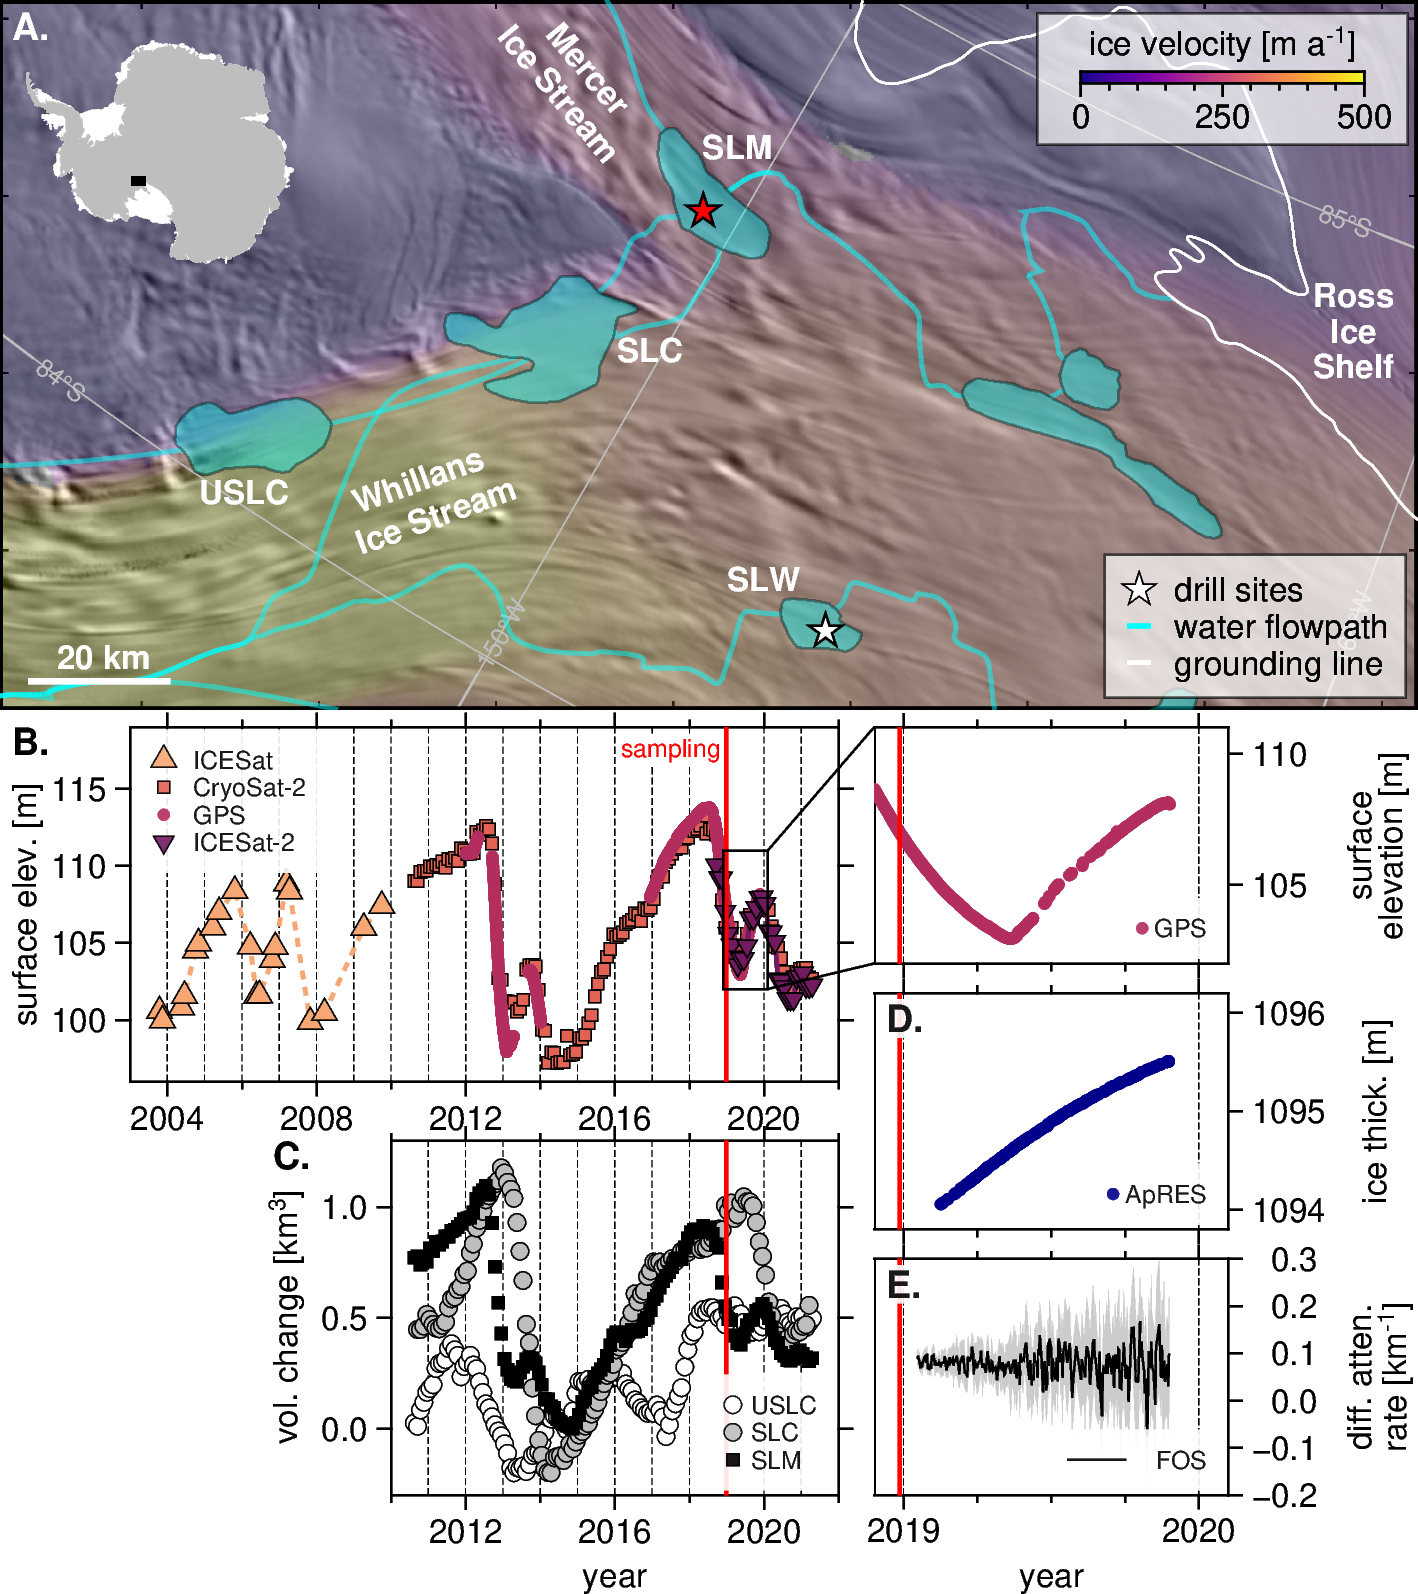

In [14]:
cs2slm = pd.read_csv('../data/cs2/timeseries/slm-20210721.dat', header = None, names = ['year','dh'])
cs2slc = pd.read_csv('../data/cs2/timeseries/slc-20210721.dat', header = None, names = ['year','dh'])
cs2uslc = pd.read_csv('../data/cs2/timeseries/uslc-20210721.dat', header = None, names = ['year','dh'])
area_slm = 143
area_slc = 267
area_uslc = 187

h_min = -0.3
h_max = 1.3

new_t_min = 2010
newwid = wid / (t_max - t_min) * (t_max - new_t_min)

newxshift = str(newwid + x_off) + 'c'

new_ts_proj = 'X' + str(newwid) + 'c/' + str(hgt) + 'c'
ts_reg = str(new_t_min) + '/' + str(t_max) + '/' + str(h_min) + '/' + str(h_max)

with pygmt.config(FONT_LABEL='8p,Helvetica', FONT_ANNOT_PRIMARY = '8p,Helvetica', 
                  MAP_GRID_PEN_PRIMARY = '0.5p,black,dashed'):
    fig.basemap(region = ts_reg, projection = new_ts_proj,
                xshift = '-' + newxshift,
                frame=['nWSe', 'xa4f2g1+l"year"', 'ya0.5'])

fig.plot(x = cs2uslc['year'], y = (cs2uslc['dh'] - cs2uslc['dh'].min())/1000 * area_uslc - 0.2, 
         style = 'c0.15c', pen = '0.25p,black', label = 'USLC', color = 'white')
fig.plot(x = cs2slc['year'], y = (cs2slc['dh'] - cs2slc['dh'].min())/1000 * area_slc - 0.2, 
         style = 'c0.15c', pen = '0.25p,black', label = 'SLC', color = 'gray')
fig.plot(x = cs2slm['year'], y = (cs2slm['dh'] - cs2slm['dh'].min())/1000 * area_slm, 
         style = 's0.15c', pen = '0.25p,black', label = 'SLM', color = 'black')

fig.text(x = new_t_min, y = (h_min+h_max)/2, text = 'vol. change [km@+3@+]',
         font = '8p,Helvetica,black', justify = 'BC', angle = 90,
         offset = '-0.8c/0c', no_clip = True)
    
fig.text(x = new_t_min, y = h_max, text = 'C.', 
         font = '9p,Helvetica-Bold,black', justify = 'TL', 
         offset = '-1c/0c', no_clip = True)
fig.plot(x = [breakthrough,breakthrough], y = [h_min,h_max], pen = '1p,red')

with pygmt.config(FONT_ANNOT_PRIMARY='6p,Helvetica'):
    fig.legend(transparency=10, position = 'JBR+jBR+o0.04c', box = '+gwhite+c0c/0c' )

fig.show()

In [15]:
# clean up
os.remove('moa.cpt')
os.remove('vel.cpt')
os.remove('SiegfriedFricker2018-outlines.h5')

# save
fig.savefig(out)